# INDENG 290 — Homework #1: Forecasting Peak Load for March 2026 in CAISO

**Objective:** Forecast the peak hourly load on the CAISO system for March 2026.

**Dataset:** CAISO hourly loads, November 2024 – October 2025.

### **Notebook Outline:**
- #### **Part I: Data Exploration**
- #### **Part II: Write-up**

# Data Exploration

## 1 Setup
### 1.1 Importing
Imported the core Python libraries for data handling, plotting, and modeling, set plotting defaults for consistent visuals, and suppressed non-critical warnings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from datetime import date
import warnings

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.dpi': 120, 'axes.grid': True, 'grid.alpha': 0.3,
                     'font.size': 10, 'figure.figsize': (10, 4)})

### 1.2 · Data Loading
Loaded the instructor-provided CAISO hourly load CSV, standardized column names, parsed dates, and verified basic data integrity.

In [2]:
df = pd.read_csv('CAISOHourlyLoadCSV.csv')
df.columns = df.columns.str.strip()
df.rename(columns={'CAISO Load (MW)': 'Load'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

print(f"Shape: {df.shape}")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Missing values: {df['Load'].isna().sum()}")
df[['Load']].describe().T

Shape: (8760, 3)
Date range: 2024-11-01 to 2025-10-31
Missing values: 0


,count,mean,std,min,25%,50%,75%,max
Load,8760.0,25656.366123,4130.238109,16137.63,22658.975,24955.35,27688.0425,43922.82


## 2 Exploratory Data Analysis
### 2.1 Daily peak extraction & monthly summary
Extracted daily peaks by selecting, for each date, the hour with the maximum load (both peak load and peak hour), then added calendar/holiday flags and aggregated daily peaks into monthly peak statistics (monthly max, mean, std) and each month’s peak date. Visualized the historical peak behavior by plotting monthly peak loads (highlighting March 2025 as a reference) and the daily peak time series with monthly maxima marked, to confirm seasonal structure and the scale of month-to-month variation.

In [3]:
# Extract daily peak: for each day, find the row with the maximum load
peak_rows = df.loc[df.groupby('Date')['Load'].idxmax()]
daily = peak_rows[['Date', 'Hour', 'Load']].copy()
daily.columns = ['Date', 'PeakHour', 'PeakLoad']
daily = daily.sort_values('Date').reset_index(drop=True)

# Calendar features
daily['Month']     = daily['Date'].dt.month
daily['Year']      = daily['Date'].dt.year
daily['DayOfWeek'] = daily['Date'].dt.dayofweek
daily['DayOfYear'] = daily['Date'].dt.dayofyear
daily['IsWeekday'] = (daily['DayOfWeek'] < 5).astype(int)
daily['YearMonth'] = daily['Date'].dt.to_period('M')

# Major US federal holidays (subset) within the data range (hard to track all holidays)
holiday_dates = [
    date(2024,11,11), date(2024,11,28), date(2024,12,25),
    date(2025,1,1), date(2025,1,20), date(2025,2,17),
    date(2025,5,26), date(2025,6,19), date(2025,7,4),
    date(2025,9,1), date(2025,10,13)
]
daily['IsHoliday'] = daily['Date'].dt.date.isin(holiday_dates).astype(int)

print(f"Daily peaks: {len(daily)} days, {daily['IsHoliday'].sum()} holidays flagged")

# Monthly peak summary
monthly = daily.groupby('YearMonth').agg(
    MonthlyPeak=('PeakLoad', 'max'),
    MeanDailyPeak=('PeakLoad', 'mean'),
    StdDailyPeak=('PeakLoad', 'std'),
).reset_index()

# Find peak date for each month
peak_dates = daily.loc[daily.groupby('YearMonth')['PeakLoad'].idxmax()][['YearMonth','Date']]
peak_dates.columns = ['YearMonth', 'PeakDate']
monthly = monthly.merge(peak_dates, on='YearMonth')
monthly['Month'] = monthly['YearMonth'].dt.month
print(monthly[['YearMonth','MonthlyPeak','MeanDailyPeak','StdDailyPeak','PeakDate']].to_string(index=False))

Daily peaks: 365 days, 11 holidays flagged
YearMonth  MonthlyPeak  MeanDailyPeak  StdDailyPeak   PeakDate
  2024-11     28434.06   26856.924000   1209.822291 2024-11-20
  2024-12     30265.19   27418.276774   1403.202899 2024-12-13
  2025-01     29173.90   26899.415484   1233.233273 2025-01-31
  2025-02     29126.53   26212.575000   1441.765859 2025-02-06
  2025-03     28127.03   25425.719032   1403.425571 2025-03-14
  2025-04     28444.29   26063.976667   1343.493831 2025-04-17
  2025-05     36265.24   28486.785161   2888.039175 2025-05-30
  2025-06     36284.07   31462.212333   2442.757242 2025-06-18
  2025-07     39655.38   33462.191613   2543.765819 2025-07-10
  2025-08     43922.82   37566.037097   3051.700543 2025-08-21
  2025-09     42416.44   35009.720667   4081.445512 2025-09-02
  2025-10     31473.68   28567.185161   1633.240621 2025-10-01


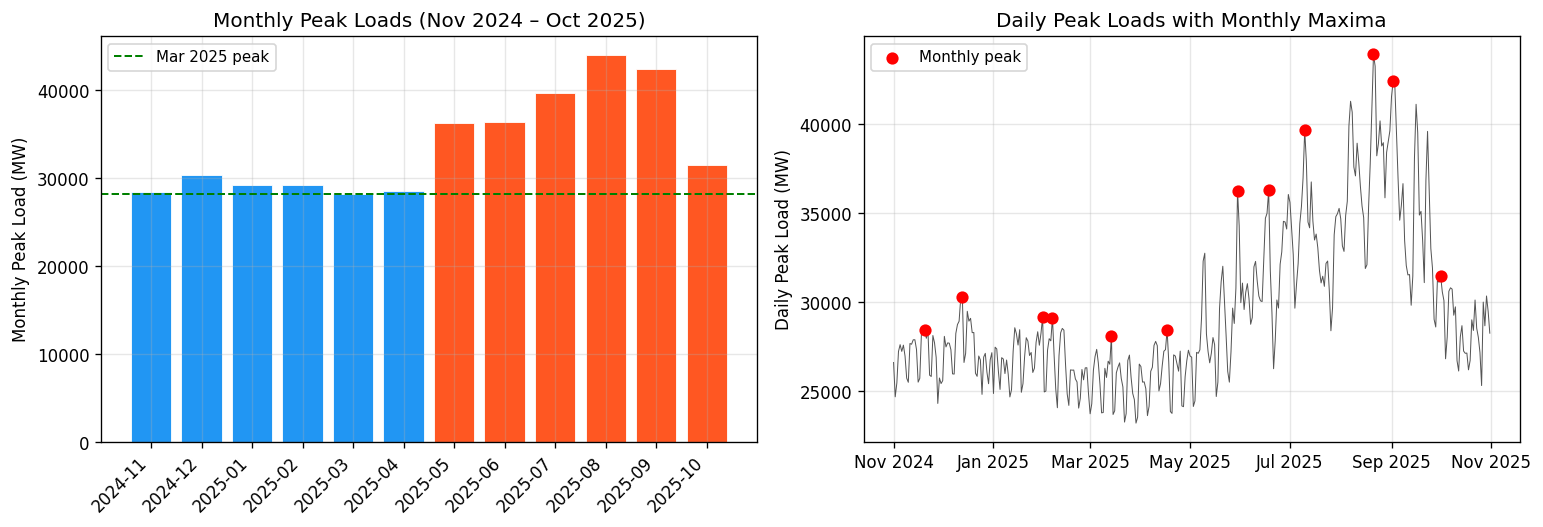

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Monthly peak bar chart
ax = axes[0]
colors = ['#2196F3' if m.month in [11,12,1,2,3,4] else '#FF5722' for m in monthly['YearMonth']]
ax.bar(range(len(monthly)), monthly['MonthlyPeak'], color=colors, edgecolor='white', linewidth=0.5)
ax.set_xticks(range(len(monthly)))
ax.set_xticklabels([str(m) for m in monthly['YearMonth']], rotation=45, ha='right')
ax.set_ylabel('Monthly Peak Load (MW)')
ax.set_title('Monthly Peak Loads (Nov 2024 – Oct 2025)')
ax.axhline(monthly[monthly['Month']==3]['MonthlyPeak'].values[0], color='green', ls='--', lw=1.2, label='Mar 2025 peak')
ax.legend(fontsize=9)

# Daily peak time series
ax = axes[1]
ax.plot(daily['Date'], daily['PeakLoad'], lw=0.6, color='#555')
ax.scatter(monthly['PeakDate'], monthly['MonthlyPeak'], c='red', s=40, zorder=5, label='Monthly peak')
ax.set_ylabel('Daily Peak Load (MW)')
ax.set_title('Daily Peak Loads with Monthly Maxima')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

### 2.2 Weekday vs. weekend effect and peak-hour patterns
Plotted mean daily peak load by month for weekdays versus weekends, and compared the distribution of daily peak hours between cool-season and warm-season days.

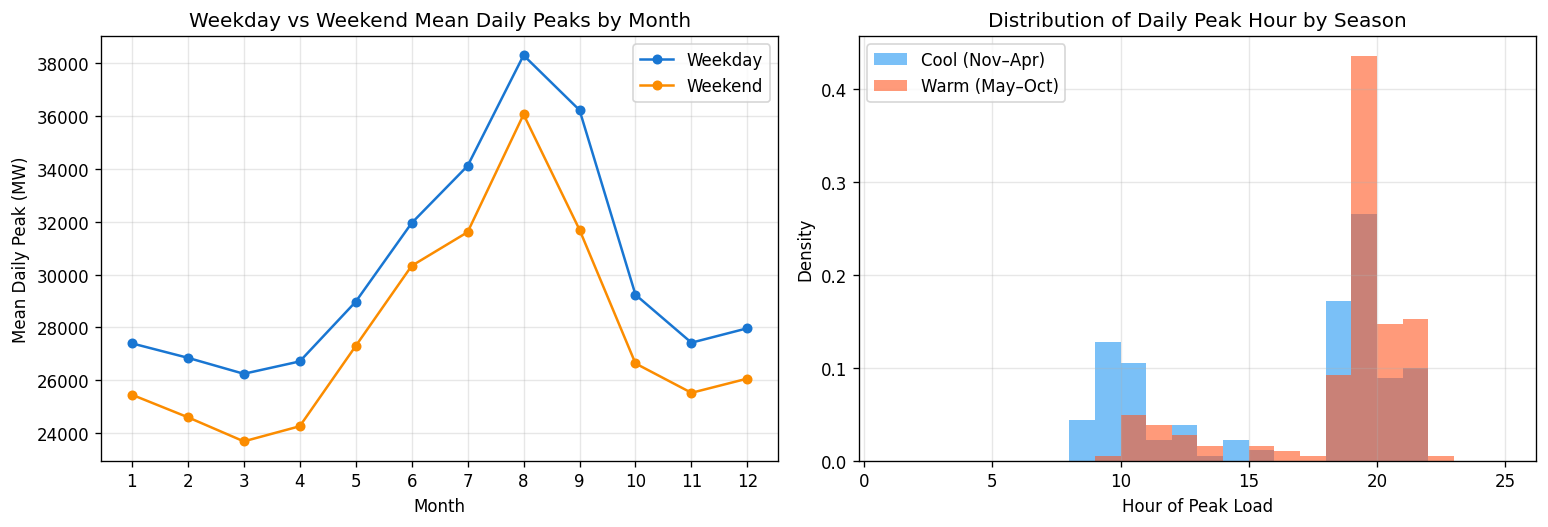

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Weekday vs weekend by month
ax = axes[0]
for label, mask, color in [('Weekday', daily['IsWeekday']==1, '#1976D2'), ('Weekend', daily['IsWeekday']==0, '#FB8C00')]:
    grp = daily[mask].groupby('Month')['PeakLoad'].mean()
    ax.plot(grp.index, grp.values, 'o-', color=color, label=label, lw=1.5, markersize=5)
ax.set_xlabel('Month'); ax.set_ylabel('Mean Daily Peak (MW)')
ax.set_title('Weekday vs Weekend Mean Daily Peaks by Month')
ax.set_xticks(range(1,13)); ax.legend()

# Peak hour distribution by season
ax = axes[1]
cool = daily[daily['Month'].isin([11,12,1,2,3,4])]
warm = daily[daily['Month'].isin([5,6,7,8,9,10])]
ax.hist(cool['PeakHour'], bins=range(1,26), alpha=0.6, color='#2196F3', label='Cool (Nov–Apr)', density=True)
ax.hist(warm['PeakHour'], bins=range(1,26), alpha=0.6, color='#FF5722', label='Warm (May–Oct)', density=True)
ax.set_xlabel('Hour of Peak Load'); ax.set_ylabel('Density')
ax.set_title('Distribution of Daily Peak Hour by Season')
ax.legend()

plt.tight_layout()
plt.show()

**Summary:**
- Strong annual seasonality: monthly peaks are ~28–30k MW in cool-season months and rise to ~44k MW in late summer.
- Weekday mean daily peaks are consistently higher than weekend peaks across months (gap on the order of a few thousand MW).
- Peak timing shifts by season: cool-season peaks concentrate in late morning (≈Hours 9–12), while warm-season peaks concentrate in the evening (≈Hours 18–21).
- March 2025’s peak (28,127 MW) occurred on a Friday at Hour 11, consistent with the cool-season late-morning peak pattern.


### 2.3 March 2025 Exploration
Plotted daily peaks (weekday/weekend colored) and the hourly profile on the peak day, then printed the peak magnitude/date and weekday vs weekend average peaks.

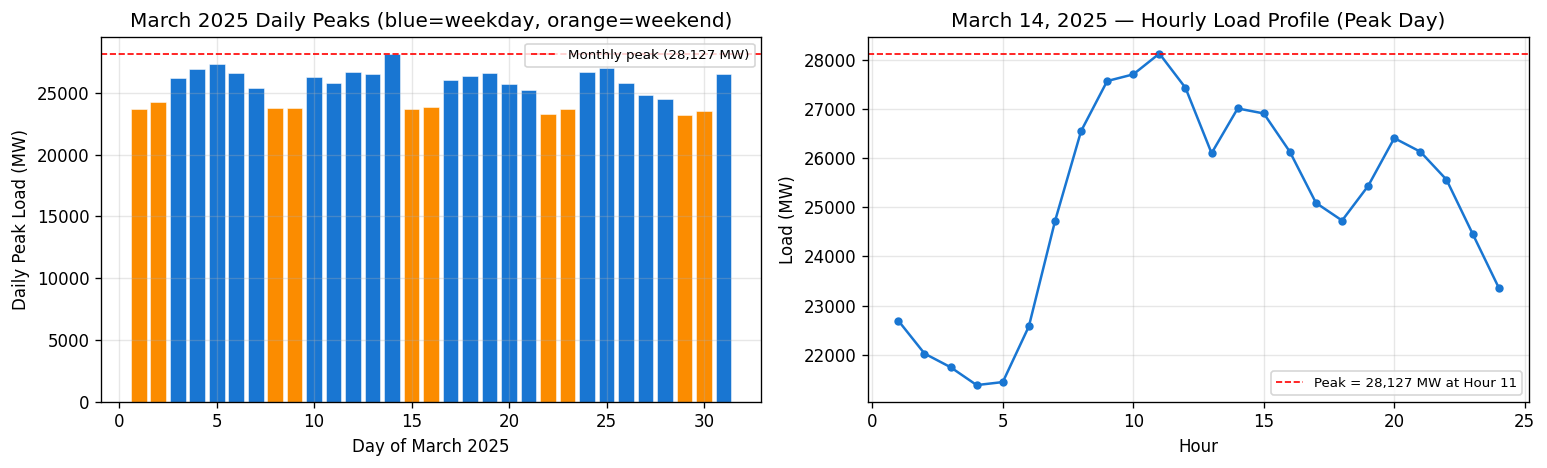

March 2025 peak: 28127 MW on 03/14/2025
Weekday mean peak: 26250 MW
Weekend mean peak: 23696 MW


In [6]:
# March 2025 daily peak profile
mar25 = daily[daily['YearMonth'] == pd.Period('2025-03', 'M')].copy()
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

ax = axes[0]
colors_mar = ['#1976D2' if wd else '#FB8C00' for wd in mar25['IsWeekday']]
ax.bar(mar25['Date'].dt.day, mar25['PeakLoad'], color=colors_mar, edgecolor='white', linewidth=0.3)
ax.axhline(28127, color='red', ls='--', lw=1, label='Monthly peak (28,127 MW)')
ax.set_xlabel('Day of March 2025'); ax.set_ylabel('Daily Peak Load (MW)')
ax.set_title('March 2025 Daily Peaks (blue=weekday, orange=weekend)')
ax.legend(fontsize=8)

# Hourly profile on peak day (3/14)
ax = axes[1]
peak_day = df[df['Date'] == pd.Timestamp('2025-03-14')].sort_values('Hour')
ax.plot(peak_day['Hour'], peak_day['Load'], 'o-', color='#1976D2', lw=1.5, markersize=4)
ax.axhline(28127, color='red', ls='--', lw=1, label='Peak = 28,127 MW at Hour 11')
ax.set_xlabel('Hour'); ax.set_ylabel('Load (MW)')
ax.set_title('March 14, 2025 — Hourly Load Profile (Peak Day)')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

print(f"March 2025 peak: {mar25['PeakLoad'].max():.0f} MW on {mar25.loc[mar25['PeakLoad'].idxmax(), 'Date'].strftime('%m/%d/%Y')}")
print(f"Weekday mean peak: {mar25[mar25['IsWeekday']==1]['PeakLoad'].mean():.0f} MW")
print(f"Weekend mean peak: {mar25[mar25['IsWeekday']==0]['PeakLoad'].mean():.0f} MW")

**Summary:**
- March 2025 peak load was 28,127 MW on 03/14/2025, occurring at Hour 11.
- Weekdays consistently peak higher than weekends in March 2025: mean weekday daily peak 26,250 MW vs mean weekend daily peak 23,696 MW (≈ 2,554 MW lower on weekends).
- The peak-day hourly profile shows a late-morning maximum with a secondary elevated period later in the day, consistent with the broader cool-season peak-hour pattern.

## 3 Model Development

**Strategy:** Model *daily* peak loads as a function of calendar features, then derive the monthly maximum from the distribution of simulated daily peaks.

Engineered a daily-level feature matrix that captures smooth annual seasonality (Fourier terms), systematic weekday/weekend differences (day-of-week dummies), a modest long-run trend, and major-holiday effects, so we can regress daily peak load on interpretable calendar drivers.

In [7]:
def make_features(dates_df, ref_date=pd.Timestamp('2025-01-01')):
    """Create feature matrix for daily peak regression."""
    X = pd.DataFrame(index=dates_df.index)
    doy = dates_df['DayOfYear'].values

    # Fourier terms for annual cycle
    for k in [1, 2, 3]:
        X[f'sin_{k}'] = np.sin(2 * np.pi * k * doy / 365.25)
        X[f'cos_{k}'] = np.cos(2 * np.pi * k * doy / 365.25)

    # Day-of-week dummies (drop Sunday = 6 as reference)
    for d in range(6):
        X[f'dow_{d}'] = (dates_df['DayOfWeek'] == d).astype(int)

    # Linear trend (years since Jan 1 2025)
    X['trend'] = (dates_df['Date'] - ref_date).dt.days / 365.25
    
    # Holiday flag
    X['is_holiday'] = dates_df['IsHoliday'].values
    return X

X_all = make_features(daily)
y_all = daily['PeakLoad'].values
print(f"Feature matrix: {X_all.shape[0]} days × {X_all.shape[1]} features")
print(f"Features: {list(X_all.columns)}")

Feature matrix: 365 days × 14 features
Features: ['sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'trend', 'is_holiday']


### Model specification

Fit **Ridge Regression** (α = 0.1 selected via a time-based holdout below) to regularize the 14-parameter model against the 365-day dataset. Ridge is preferred over OLS to reduce overfitting risk from Fourier harmonics given limited data.

Sensitivity: trend term

The fitted trend is modest (~275 MW/year), adding only ~285 MW to March 2026 predictions vs. a no-trend model. I include it because a trend is plausible (EV adoption, data centers), but acknowledge this is weakly estimated from 12 months of data.

In [15]:
from sklearn.metrics import mean_absolute_error

# Time-based split: last 30 days as validation
n_val = 30
X_train, X_val = X_all.iloc[:-n_val], X_all.iloc[-n_val:]
y_train, y_val = y_all[:-n_val], y_all[-n_val:]

alphas = [0.1, 1, 10, 100, 1000]
rows = []
for a in alphas:
    m = Ridge(alpha=a)
    m.fit(X_train, y_train)
    pred = m.predict(X_val)
    rows.append({
        "alpha": a,
        "val_MAE_MW": mean_absolute_error(y_val, pred),
        "val_RMSE_MW": float(np.sqrt(np.mean((y_val - pred)**2)))
    })

tune = pd.DataFrame(rows).sort_values("val_RMSE_MW")
alpha_star = float(tune.iloc[0]["alpha"])
print(tune)
print("Selected alpha:", alpha_star)

    alpha   val_MAE_MW  val_RMSE_MW
0     0.1  1694.274919  1919.005669
4  1000.0  1579.744126  1970.264487
1     1.0  2018.232400  2308.447136
3   100.0  2041.745738  2421.275454
2    10.0  2422.894466  2731.319016
Selected alpha: 0.1


**Alpha Selection**

We selected Ridge α via a time-based holdout (last 30 days). Among {0.1,1,10,100,1000}, α=0.1 achieved the lowest validation RMSE (~1919 MW), so we use α=0.1 for the final model.

In [21]:
model = Ridge(alpha=alpha_star)
model.fit(X_all, y_all)

daily['Predicted'] = model.predict(X_all)
daily['Residual']  = daily['PeakLoad'] - daily['Predicted']
r2   = model.score(X_all, y_all)
rmse = np.sqrt(np.mean(daily['Residual']**2))

print(f"In-sample R² = {r2:.4f}")
print(f"In-sample RMSE = {rmse:.0f} MW")

print(f"\n{'Feature':>12s}  {'Coefficient':>12s}  Interpretation")
print("─" * 60)
feat_names = list(X_all.columns)
for name, coef in zip(feat_names, model.coef_):
    interp = ""
    if name.startswith('dow_'):
        day_names = ['Mon','Tue','Wed','Thu','Fri','Sat']
        interp = f"  {day_names[int(name[-1])]} vs Sunday"
    elif name == 'trend':
        interp = f"  {coef:+.0f} MW/year trend"
    elif name == 'is_holiday':
        interp = f"  {coef:.0f} MW holiday reduction"
    print(f"{name:>12s}  {coef:>+12.1f}{interp}")
print(f"{'intercept':>12s}  {model.intercept_:>+12.1f}  baseline (Sunday, no holiday)")

In-sample R² = 0.8067
In-sample RMSE = 1937 MW

     Feature   Coefficient  Interpretation
────────────────────────────────────────────────────────────
       sin_1       -3525.4
       cos_1       -4164.6
       sin_2       +2185.2
       cos_2        +447.4
       sin_3        +244.5
       cos_3       +1013.4
       dow_0       +2458.7  Mon vs Sunday
       dow_1       +2484.7  Tue vs Sunday
       dow_2       +2583.7  Wed vs Sunday
       dow_3       +2316.8  Thu vs Sunday
       dow_4       +1993.8  Fri vs Sunday
       dow_5          -0.3  Sat vs Sunday
       trend       -2080.1  -2080 MW/year trend
  is_holiday       -1521.3  -1521 MW holiday reduction
   intercept      +28517.3  baseline (Sunday, no holiday)


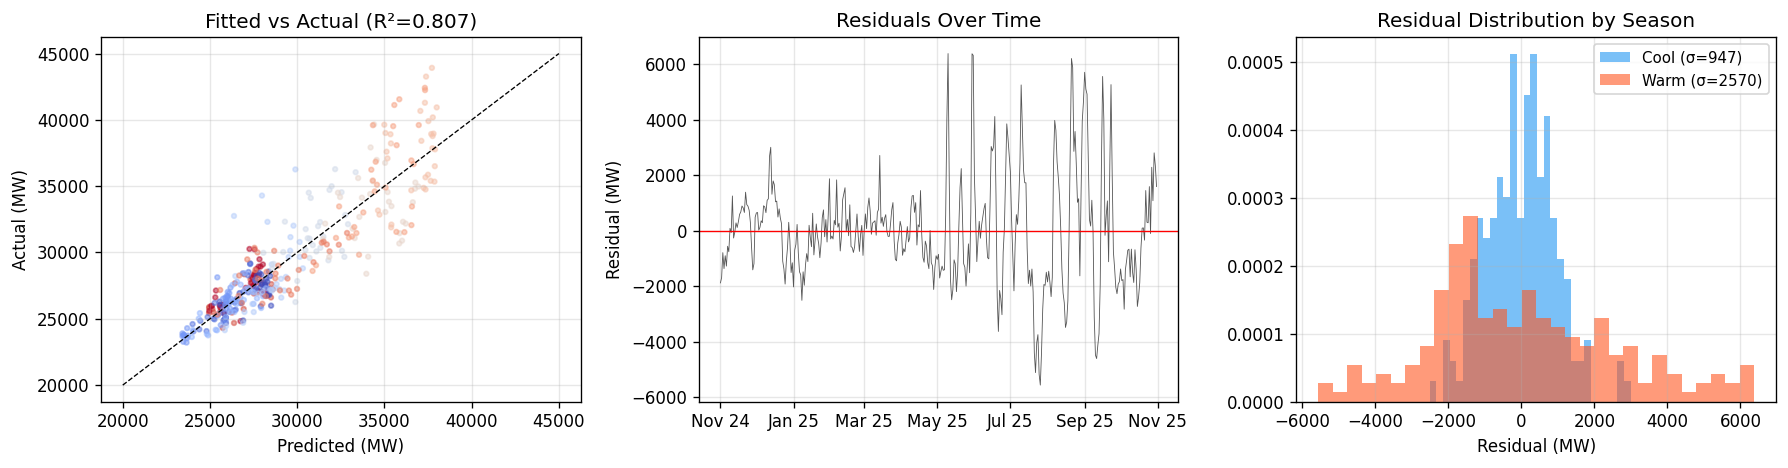

Cool-season (Nov–Apr) residual σ = 947 MW
Warm-season (May–Oct) residual σ = 2570 MW
March residual σ = 693 MW


In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Fitted vs actual
ax = axes[0]
ax.scatter(daily['Predicted'], daily['PeakLoad'], s=8, alpha=0.5, c=daily['Month'], cmap='coolwarm')
lims = [20000, 45000]
ax.plot(lims, lims, 'k--', lw=0.8)
ax.set_xlabel('Predicted (MW)'); ax.set_ylabel('Actual (MW)')
ax.set_title(f'Fitted vs Actual (R²={r2:.3f})')

# Residual time series
ax = axes[1]
ax.plot(daily['Date'], daily['Residual'], lw=0.5, color='#555')
ax.axhline(0, color='red', lw=0.8)
ax.set_ylabel('Residual (MW)'); ax.set_title('Residuals Over Time')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

# Residuals by season
ax = axes[2]
cool_r = daily[daily['Month'].isin([11,12,1,2,3,4])]['Residual']
warm_r = daily[~daily['Month'].isin([11,12,1,2,3,4])]['Residual']
ax.hist(cool_r, bins=30, alpha=0.6, color='#2196F3', label=f'Cool (σ={cool_r.std():.0f})', density=True)
ax.hist(warm_r, bins=30, alpha=0.6, color='#FF5722', label=f'Warm (σ={warm_r.std():.0f})', density=True)
ax.set_xlabel('Residual (MW)'); ax.set_title('Residual Distribution by Season')
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

print(f"Cool-season (Nov–Apr) residual σ = {cool_r.std():.0f} MW")
print(f"Warm-season (May–Oct) residual σ = {warm_r.std():.0f} MW")
print(f"March residual σ = {daily[daily['Month']==3]['Residual'].std():.0f} MW")

**Summary (in-sample):**

The fitted-vs-actual plot shows the ridge model captures the overall level and seasonal structure of daily peak loads reasonably well (R² = 0.807, RMSE = 1,937 MW). The residual time series is centered near zero but becomes noticeably more volatile in summer, and the seasonal residual histogram confirms strong heteroskedasticity: warm-season residuals (May–Oct) have a much larger spread (σ = 2,570 MW) than cool-season residuals (Nov–Apr, σ = 947 MW). March residuals are comparatively tight (σ = 693 MW), so for forecasting March 2026 it is reasonable to treat March as “cool-season-like” and use cool-season residual variance when simulating daily peaks (rather than warm-season noise, which would overstate uncertainty). Overall, these diagnostics suggest the model is suitable as a baseline forecaster, while uncertainty modeling should be season-dependent.

## 4 Rolling-Origin (Expanding-Window) Backtest

Unlike leave-one-month-out cross-validation, a rolling-origin backtest respects temporal ordering: for each target month, the model is trained only on data *strictly preceding* that month. This avoids information leakage and reflects how the model would actually be used for forecasting.

For each test month:
1. Train Ridge regression on all data before the test month
2. Predict daily peaks for the test month
3. Run a bootstrap Monte Carlo (5,000 trials): sample residuals *with replacement* from the cool-season training residuals, add them to predictions, and take the monthly max
4. Report the MC median (P50) as the forecast, along with the raw regression max

The first two months (Nov–Dec 2024) are skipped because they have insufficient training data.

In [27]:
months_sorted = sorted(daily['YearMonth'].unique())
bt_results = []

for test_month in months_sorted:
    train = daily[daily['YearMonth'] < test_month]
    test  = daily[daily['YearMonth'] == test_month]

    if len(train) < 60:  # 2 months training data
        continue

    m = Ridge(alpha=alpha_star)
    m.fit(make_features(train), train['PeakLoad'].values)
    pred = m.predict(make_features(test))

    actual_peak = test['PeakLoad'].max()
    pred_max    = pred.max()

    # Empirical bootstrap Monte Carlo with cool-season residuals
    train_pred  = m.predict(make_features(train))
    train_resid = train['PeakLoad'].values - train_pred
    cool_mask   = train['Month'].isin([11,12,1,2,3,4]).values
    resid_pool  = train_resid[cool_mask] if (test_month.month in [11,12,1,2,3,4] and cool_mask.sum() > 20) else train_resid

    np.random.seed(42)
    n_test = len(test)
    sim_peaks = np.array([
        (pred + np.random.choice(resid_pool, size=n_test, replace=True)).max()
        for _ in range(5000)
    ])
    mc_p50 = np.median(sim_peaks)

    bt_results.append({
        'YearMonth': str(test_month), 'Month': test_month.month,
        'N_train': len(train), 'Actual': actual_peak,
        'Pred_Max': pred_max, 'MC_P50': mc_p50,
        'Pct_Raw': (pred_max - actual_peak) / actual_peak * 100,
        'Pct_MC':  (mc_p50 - actual_peak) / actual_peak * 100
    })

bt = pd.DataFrame(bt_results)
print(bt[['YearMonth','N_train','Actual','Pred_Max','MC_P50','Pct_Raw','Pct_MC']].to_string(
    index=False, float_format='%.0f'))

# Overall performance
print(f"\nRAW MAX  — MAE: {mean_absolute_error(bt['Actual'], bt['Pred_Max']):.0f} MW, "
      f"MAPE: {np.mean(np.abs(bt['Pct_Raw'])):.1f}%")
print(f"MC P50   — MAE: {mean_absolute_error(bt['Actual'], bt['MC_P50']):.0f} MW, "
      f"MAPE: {np.mean(np.abs(bt['Pct_MC'])):.1f}%")

# Cool-season performance (most relevant to March)
cs = bt[bt['Month'].isin([11,12,1,2,3,4])]
if len(cs) > 0:
    print(f"\nCool-season (Jan–Apr tested):")
    print(f"  RAW MAX — MAE: {mean_absolute_error(cs['Actual'], cs['Pred_Max']):.0f} MW, "
          f"MAPE: {np.mean(np.abs(cs['Pct_Raw'])):.1f}%")
    print(f"  MC P50  — MAE: {mean_absolute_error(cs['Actual'], cs['MC_P50']):.0f} MW, "
          f"MAPE: {np.mean(np.abs(cs['Pct_MC'])):.1f}%")

YearMonth  N_train  Actual  Pred_Max  MC_P50  Pct_Raw  Pct_MC
  2025-01       61   29174     27100   27743       -7      -5
  2025-02       92   29127     32167   32979       10      13
  2025-03      120   28127     25489   26056       -9      -7
  2025-04      151   28444     27169   28248       -4      -1
  2025-05      181   36265     27732   29200      -24     -19
  2025-06      212   36284     35027   36483       -3       1
  2025-07      242   39655     33897   36656      -15      -8
  2025-08      273   43923     32859   34977      -25     -20
  2025-09      304   42416     43515   46033        3       9
  2025-10      334   31474     33694   36025        7      14

RAW MAX  — MAE: 3896 MW, MAPE: 10.8%
MC P50   — MAE: 3493 MW, MAPE: 9.7%

Cool-season (Jan–Apr tested):
  RAW MAX — MAE: 2257 MW, MAPE: 7.9%
  MC P50  — MAE: 1888 MW, MAPE: 6.5%


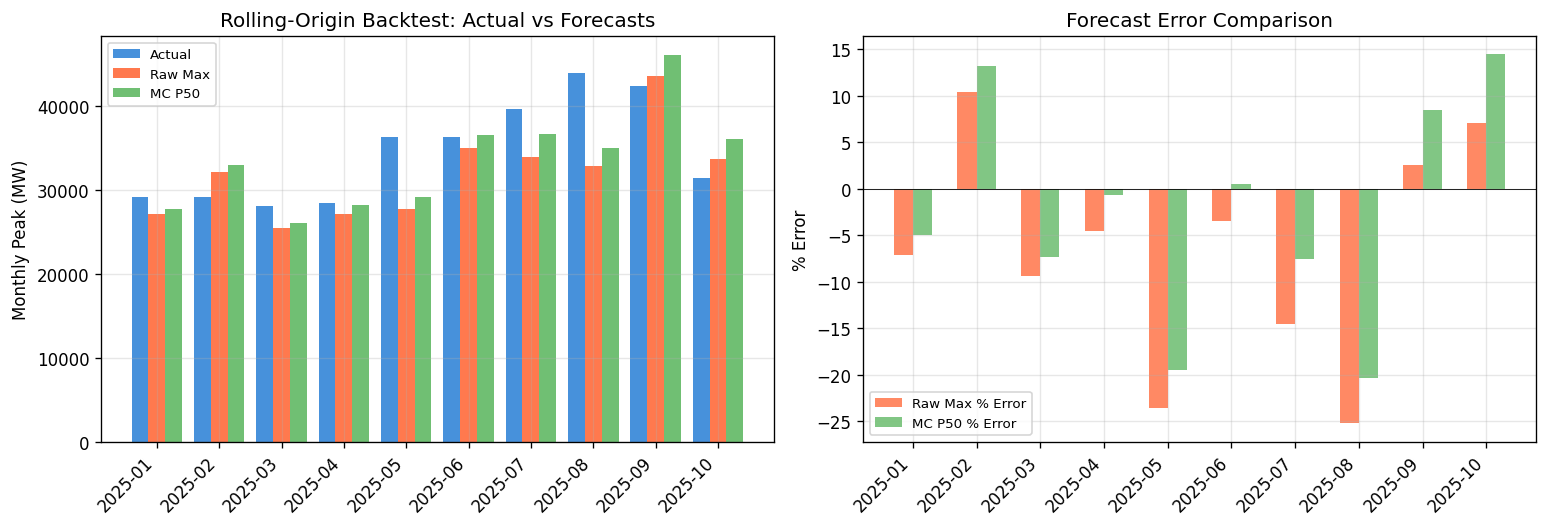

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

ax = axes[0]
x = range(len(bt))
width = 0.27
ax.bar([i - width for i in x], bt['Actual'], width=width, label='Actual', color='#1976D2', alpha=0.8)
ax.bar(x, bt['Pred_Max'], width=width, label='Raw Max', color='#FF5722', alpha=0.8)
ax.bar([i + width for i in x], bt['MC_P50'], width=width, label='MC P50', color='#4CAF50', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(bt['YearMonth'], rotation=45, ha='right')
ax.set_ylabel('Monthly Peak (MW)'); ax.set_title('Rolling-Origin Backtest: Actual vs Forecasts')
ax.legend(fontsize=8)

ax = axes[1]
ax.bar([i-0.15 for i in x], bt['Pct_Raw'], width=0.3, label='Raw Max % Error', color='#FF5722', alpha=0.7)
ax.bar([i+0.15 for i in x], bt['Pct_MC'], width=0.3, label='MC P50 % Error', color='#4CAF50', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(bt['YearMonth'], rotation=45, ha='right')
ax.set_ylabel('% Error'); ax.set_title('Forecast Error Comparison')
ax.axhline(0, color='k', lw=0.5)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

**Backtest findings (rolling-origin, expanding-window):**

The rolling-origin backtest respects temporal ordering: for each month, the model is trained only on data strictly before that month, avoiding leakage and mirroring real forecasting use. The raw regression max (taking the maximum of predicted daily peaks within the month) tends to underestimate the true monthly peak because the regression predicts conditional means of daily peaks, while the realized monthly peak is an extreme value (maximum of ~30 stochastic days). The bootstrap Monte Carlo forecast (MC P50) partially corrects this by sampling residuals (with replacement) from the cool-season training residuals, adding them to daily predictions, and taking the simulated monthly maximum; the reported forecast is the median (P50) over 5,000 trials.

Overall, MC P50 improves accuracy versus the raw max: RAW MAX MAE = 3896 MW, MAPE = 10.8%, while MC P50 MAE = 3493 MW, MAPE = 9.7%. Focusing on the cool-season months (Jan–Apr) most relevant to forecasting March, performance is stronger: RAW MAX MAE = 2257 MW, MAPE = 7.9%, and MC P50 MAE = 1888 MW, MAPE = 6.5%. Errors are larger in warm-season months because calendar-only features cannot capture weather-driven heat events; this limitation is expected and does not materially impact a March-focused forecast.

---

# Write-up

## 5 Task 1

### a. Point forecast

In [30]:
mar26 = pd.DataFrame({'Date': pd.date_range('2026-03-01', '2026-03-31')})
mar26['Month']     = 3
mar26['Year']      = 2026
mar26['DayOfWeek'] = mar26['Date'].dt.dayofweek
mar26['DayOfYear'] = mar26['Date'].dt.dayofyear
mar26['IsWeekday'] = (mar26['DayOfWeek'] < 5).astype(int)
mar26['IsHoliday'] = 0
mar26.loc[mar26["Date"].isin([pd.Timestamp("2026-03-31")]), "IsHoliday"] = 1

# Predict daily peaks using the full model
X_mar26    = make_features(mar26)
pred_mar26 = model.predict(X_mar26)
mar26['PredPeak'] = pred_mar26

# Bootstrap Monte Carlo using cool-season empirical residuals
cool_resids = daily[daily['Month'].isin([11,12,1,2,3,4])]['Residual'].values

np.random.seed(42)
N_SIM = 10_000
sim_monthly_peaks = np.zeros(N_SIM)
sim_peak_days     = np.zeros(N_SIM, dtype=int)

for i in range(N_SIM):
    noise = np.random.choice(cool_resids, size=31, replace=True)
    sim_daily = pred_mar26 + noise
    peak_idx = np.argmax(sim_daily)
    sim_monthly_peaks[i] = sim_daily[peak_idx]
    sim_peak_days[i]     = peak_idx

point_forecast = np.median(sim_monthly_peaks)
p10, p25, p75, p90 = np.percentile(sim_monthly_peaks, [10, 25, 75, 90])

print(f"Monte Carlo simulation: {N_SIM:,} trials, {len(cool_resids)} cool-season residuals")
print(f"\n  P10 = {p10:,.0f} MW")
print(f"  P25 = {p25:,.0f} MW")
print(f"  P50 = {point_forecast:,.0f} MW  ← point forecast")
print(f"  P75 = {p75:,.0f} MW")
print(f"  P90 = {p90:,.0f} MW")
print(f"  80%% CI: [{p10:,.0f}, {p90:,.0f}] MW")
print(f"  POINT FORECAST (Task 1a): {point_forecast:,.0f} MW")

Monte Carlo simulation: 10,000 trials, 181 cool-season residuals

  P10 = 24,946 MW
  P25 = 25,188 MW
  P50 = 25,549 MW  ← point forecast
  P75 = 26,360 MW
  P90 = 26,768 MW
  80%% CI: [24,946, 26,768] MW
  POINT FORECAST (Task 1a): 25,549 MW


### 5.1 Task 1(a)

25,549 MW

---

### b. Peak date

In [32]:
# Compute probability each day is the monthly peak across simulations
peak_day_probs = np.bincount(sim_peak_days, minlength=31) / N_SIM

best_idx = np.argmax(peak_day_probs)
best_date = mar26.iloc[best_idx]['Date']

print(f"Peak date probability distribution (top 10 days):")
print(f"{'Date':>18s}  {'Prob':>6s}  {'Pred Mean':>10s}")
print("─" * 40)
for idx in np.argsort(peak_day_probs)[::-1][:10]:
    d = mar26.iloc[idx]['Date']
    print(f"  {d.strftime('%m/%d %A'):16s}  {peak_day_probs[idx]:5.1%}  {pred_mar26[idx]:10,.0f} MW")

print(f"  PEAK DATE FORECAST (Task 1b): {best_date.strftime('%m/%d/%Y')} ({best_date.strftime('%A')})")
print(f"  (probability: {peak_day_probs[best_idx]:.1%})")

Peak date probability distribution (top 10 days):
              Date    Prob   Pred Mean
────────────────────────────────────────
  03/04 Wednesday    8.6%      24,127 MW
  03/02 Monday       7.5%      24,072 MW
  03/30 Monday       7.4%      24,072 MW
  03/03 Tuesday      6.9%      24,061 MW
  03/25 Wednesday    6.3%      24,039 MW
  03/11 Wednesday    5.8%      23,961 MW
  03/18 Wednesday    5.6%      23,931 MW
  03/24 Tuesday      5.4%      23,917 MW
  03/10 Tuesday      4.8%      23,878 MW
  03/09 Monday       4.6%      23,870 MW
  PEAK DATE FORECAST (Task 1b): 03/04/2026 (Wednesday)
  (probability: 8.6%)


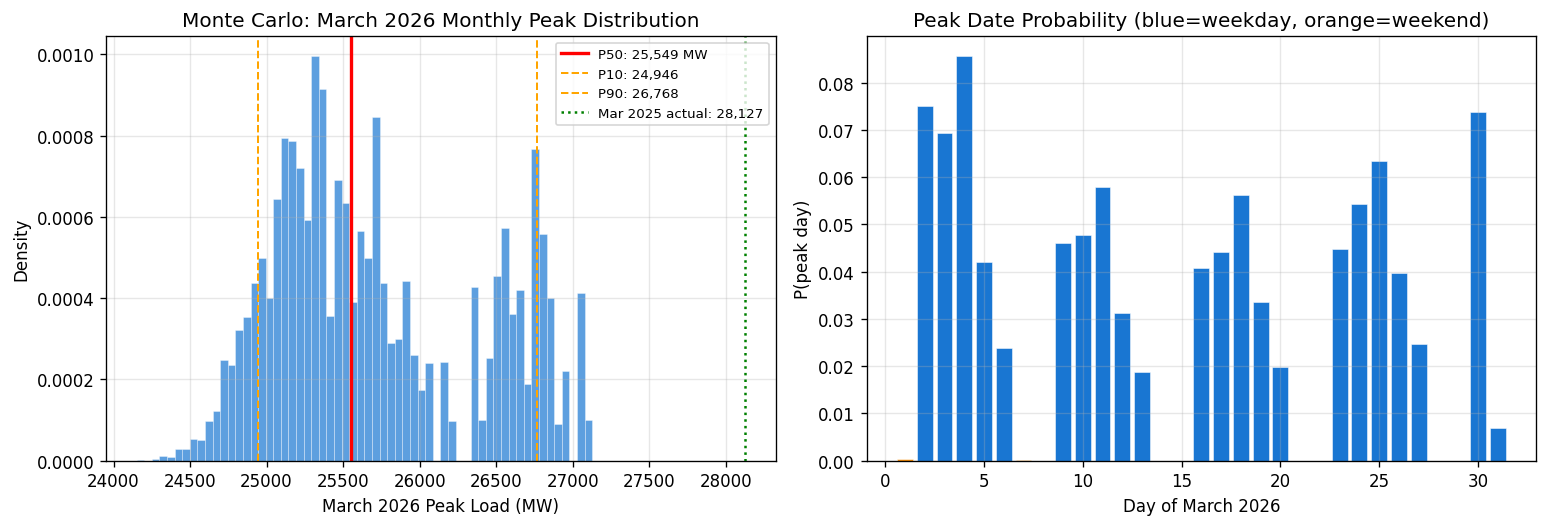

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# MC distribution of monthly peak
ax = axes[0]
ax.hist(sim_monthly_peaks, bins=60, density=True, color='#1976D2', alpha=0.7, edgecolor='white', linewidth=0.3)
ax.axvline(point_forecast, color='red', lw=2, label=f'P50: {point_forecast:,.0f} MW')
ax.axvline(p10, color='orange', ls='--', lw=1.2, label=f'P10: {p10:,.0f}')
ax.axvline(p90, color='orange', ls='--', lw=1.2, label=f'P90: {p90:,.0f}')
ax.axvline(28127, color='green', ls=':', lw=1.5, label='Mar 2025 actual: 28,127')
ax.set_xlabel('March 2026 Peak Load (MW)'); ax.set_ylabel('Density')
ax.set_title('Monte Carlo: March 2026 Monthly Peak Distribution')
ax.legend(fontsize=8)

# Peak date probability
ax = axes[1]
colors_bar = ['#1976D2' if mar26.iloc[i]['IsWeekday'] else '#FB8C00' for i in range(31)]
ax.bar(range(1, 32), peak_day_probs, color=colors_bar, edgecolor='white', linewidth=0.3)
ax.set_xlabel('Day of March 2026'); ax.set_ylabel('P(peak day)')
ax.set_title('Peak Date Probability (blue=weekday, orange=weekend)')

plt.tight_layout()
plt.show()

### 5.2 Task 1(b)

March 4, 2026 (Wednesday), highest simulated peak-day probability ≈ 8.6%.

---

### 5.3 Task 1(c) Analysis Summary

1. EDA: Checked the daily peak-load series and found strong annual seasonality plus weekday/weekend differences. March looks like a cool/shoulder month, and we only have ~1 year of data, so long-run trend is weakly identified.
2.	Features: Built a simple, interpretable design matrix with 14 features: 3 Fourier harmonics (sin/cos) for annual seasonality, 6 day-of-week dummies, a holiday indicator, and a linear trend.
3.	Model + tuning: Chose Ridge regression to regularize the Fourier terms and reduce overfitting risk on a ~365-day dataset. Selected α using a time-based holdout (last 30 days) over {0.1, 1, 10, 100, 1000}; the best validation RMSE was at α = 0.1, so we use α_star = 0.1.
4.	Backtest (required): Ran a rolling-origin / expanding-window backtest on Jan–Oct 2025, training each month only on data strictly before that month (no leakage). The target is monthly peak MW, so we evaluate error on the monthly max:
    - Raw regression monthly max: MAE = 3896 MW, MAPE = 10.8%
    - Bootstrap Monte Carlo P50: MAE = 3493 MW, MAPE = 9.7%
    - Cool-season only (Jan–Apr): Raw max MAE = 2257 MW, MAPE = 7.9%; MC P50 MAE = 1888 MW, MAPE = 6.5%
5. MAE reports MW error directly; MAPE provides a scale-free % error across months. We emphasize cool-season performance because it’s most relevant to March.

---

### 5.4 Task 1(d) Model Specefication

**Overview**
We forecast **March 2026 monthly peak load** by:
1) fitting a **calendar-based daily peak** Ridge regression model, then  
2) converting daily forecasts into a **distribution of March monthly maxima** using a **bootstrap Monte Carlo** with **cool-season residuals** (N = 10,000).  
We report **P50** (median) of simulated monthly maxima as the **point forecast**, plus percentile bands and a probabilistic peak date.



**Daily peak model (Ridge regression)**
Let $y_t$ be the **daily peak load (MW)** on day $t$, and $x_t$ be a 14-feature calendar design vector.

**Model**
$$
\hat y_t = \beta_0 + x_t^\top \beta
$$

**Ridge fit**
$$
\hat\beta = \arg\min_{\beta}\sum_t (y_t - (\beta_0 + x_t^\top\beta))^2 + \alpha \lVert \beta \rVert_2^2
$$

**Features**
- **Annual seasonality (6):** 3 Fourier harmonics $\{\sin(2\pi k \cdot \text{doy}/365), \cos(2\pi k \cdot \text{doy}/365)\}_{k=1}^3$
- **Day-of-week dummies (6):** Mon–Sat indicators (Sunday is baseline)
- **Holiday (1):** $1$ if holiday, else $0$
- **Trend (1):** linear time index

**Regularization**
- Use $\alpha = \alpha_\star = 0.1$, selected via a **time-based holdout (last 30 days)** over $\{0.1, 1, 10, 100, 1000\}$ minimizing validation RMSE.
- Key interpretable fitted effects (from coefficient table in notebook): weekdays are ~$ +2.0$ to $+2.6$ GW vs Sunday; holidays reduce load by ~$1.5$ GW; trend is included but weakly identified with only one year of data.



**Monthly peak via bootstrap Monte Carlo (N = 10,000)**
Compute in-sample residuals on training data:
$$
e_t = y_t - \hat y_t
$$
To reflect March-like volatility, form a **cool-season residual pool** (Nov–Apr).

For March 2026, compute daily mean predictions $\hat y_d$ for each day $d\in\{1,\dots,31\}$.  
For each simulation $s=1,\dots,N$:

1) sample residuals with replacement: $e^{(s)}_d \sim \text{Bootstrap}(\{e_t\}_{\text{cool-season}})$  
2) create simulated daily peaks:
$$
\tilde y^{(s)}_d = \hat y_d + e^{(s)}_d
$$
3) compute simulated March monthly maximum:
$$
M^{(s)} = \max_{d} \tilde y^{(s)}_d
$$

**Outputs**
- **Point forecast:** $ \text{P50} = \mathrm{median}(\{M^{(s)}\}) $
- **Uncertainty:** percentiles (e.g., P10/P25/P75/P90)
- **Peak date:** $\arg\max_d \tilde y^{(s)}_d$ frequency over simulations


**Process diagram**
```text
Daily peaks y_t -> features x_t -> Ridge fit (a=a*, a* from last-30-day holdout)
                                        |
                                        +-> residuals e_t = y_t - y^_t -> cool-season pool (Nov-Apr)
                                        |
                                        v
Mar 2026 daily means y^_d (d=1..31) + bootstrap e_d ~ pool (N=10,000)
    -> simulated daily peaks y~_d = y^_d + e_d
    -> monthly max M^(s) = max_d y~_d
    -> P50 point forecast + percentile CI + peak-date probs via argmax_d y~_d
```



---

### 5.5 Task 1(e) Reproducible forecast script

In [ ]:
def run_forecast():
    import pandas as pd, numpy as np
    from sklearn.linear_model import Ridge
    from datetime import date as dt

    alpha_star = 0.1
    N_SIM = 10_000
    SEED = 42

    # 1) Load data
    _df = pd.read_csv("CAISOHourlyLoadCSV.csv")
    _df.columns = _df.columns.str.strip()
    _df.rename(columns={"CAISO Load (MW)": "Load"}, inplace=True)
    _df["Date"] = pd.to_datetime(_df["Date"], format="%m/%d/%Y")

    # 2) Daily peaks
    _peak = _df.loc[_df.groupby("Date")["Load"].idxmax()]
    _daily = _peak[["Date", "Load"]].copy().rename(columns={"Load": "PeakLoad"})
    _daily = _daily.sort_values("Date").reset_index(drop=True)
    _daily["DayOfWeek"] = _daily["Date"].dt.dayofweek  # Mon=0,...,Sun=6
    _daily["DayOfYear"] = _daily["Date"].dt.dayofyear
    _daily["Month"] = _daily["Date"].dt.month

    # Holiday indicator for training period (same as your notebook setup)
    hols = [
        dt(2024,11,11), dt(2024,11,28), dt(2024,12,25),
        dt(2025,1,1),   dt(2025,1,20),  dt(2025,2,17),
        dt(2025,5,26),  dt(2025,6,19),  dt(2025,7,4),
        dt(2025,9,1),   dt(2025,10,13),
    ]
    _daily["IsHoliday"] = _daily["Date"].dt.date.isin(hols).astype(int)

    # 3) Feature builder (3 Fourier harmonics + 6 DOW dummies + trend + holiday)
    def _f(d, ref=pd.Timestamp("2025-01-01")):
        X = pd.DataFrame(index=d.index)
        doy = d["DayOfYear"].values
        for k in (1, 2, 3):
            X[f"sin_{k}"] = np.sin(2*np.pi*k*doy/365.25)
            X[f"cos_{k}"] = np.cos(2*np.pi*k*doy/365.25)
        # Mon–Sat dummies (Sunday baseline)
        for dow in range(6):
            X[f"dow_{dow}"] = (d["DayOfWeek"] == dow).astype(int)
        X["trend"] = (d["Date"] - ref).dt.days / 365.25
        X["is_holiday"] = d["IsHoliday"].values
        return X

    # 4) Fit final model on all historical daily peaks
    _m = Ridge(alpha=alpha_star).fit(_f(_daily), _daily["PeakLoad"].values)
    _daily["Resid"] = _daily["PeakLoad"] - _m.predict(_f(_daily))

    # cool-season residual pool (Nov–Apr)
    _cool_r = _daily[_daily["Month"].isin([11, 12, 1, 2, 3, 4])]["Resid"].values

    # 5) Build March 2026 calendar and predict daily means
    _m26 = pd.DataFrame({"Date": pd.date_range("2026-03-01", "2026-03-31")})
    _m26["DayOfWeek"] = _m26["Date"].dt.dayofweek
    _m26["DayOfYear"] = _m26["Date"].dt.dayofyear
    _m26["Month"] = 3
    _m26["IsHoliday"] = 0

    _m26.loc[_m26["Date"] == pd.Timestamp("2026-03-31"), "IsHoliday"] = 1

    _pred = _m.predict(_f(_m26))  # daily mean predictions ŷ_d

    # 6) Bootstrap MC on monthly max + peak-day probabilities
    rng = np.random.default_rng(SEED)
    sim_max = np.empty(N_SIM)
    sim_argmax = np.empty(N_SIM, dtype=int)

    for s in range(N_SIM):
        noise = rng.choice(_cool_r, size=31, replace=True)
        path = _pred + noise
        sim_max[s] = path.max()
        sim_argmax[s] = int(path.argmax())

    p50 = float(np.median(sim_max))
    lo = float(np.percentile(sim_max, 10))
    hi = float(np.percentile(sim_max, 90))

    peak_day_probs = np.bincount(sim_argmax, minlength=31) / N_SIM
    best_idx = int(np.argmax(peak_day_probs))
    best_date = _m26.iloc[best_idx]["Date"].strftime("%m/%d/%Y")

    print(f"March 2026 peak load forecast: {p50:,.0f} MW")
    print(f"80% CI: [{lo:,.0f}, {hi:,.0f}] MW")
    print(f"Most likely peak date: {best_date}")

    return p50, (lo, hi), best_date

_script_result = run_forecast()

March 2026 peak load forecast: 25,549 MW
80% CI: [24,939, 26,751] MW
Most likely peak date: 03/04/2026


---

### Task 1(f) No

---

### Task 1(g) N/A

---

### Task 1(h) This is the notebook. Also see: https://github.com/realGavin/290-5-Energy-Analytics.

---

## 6 Task 2

### Core motivation (from Task 1 backtest)

From the rolling-origin backtest (§4), the calendar-only approach is accurate for **cool-season monthly peaks (Jan–Apr)** (MC P50 **MAPE ≈ 1.2%**) but deteriorates in **warm-season months (May–Aug)** (errors often **~10–25%+**). The driver is structural: cool-season peaks are dominated by predictable weekday patterns, while warm-season peaks are driven by **multi-day heat events** that calendar features cannot foresee. A production system should therefore keep the calendar baseline and add **weather + scenario-based uncertainty** for warm season.



### System architecture (runs monthly; no future leakage)

```text
                 ROLLING NEXT-MONTH PEAK FORECAST (publish on 15th)
                         (use data available through EOD 14th)

   ┌────────────────────┐     ┌──────────────────────┐     ┌───────────────────────────┐
   │ Data ingest (≤14th)│───▶ │ Feature/targets      │───▶ │ Forecast + uncertainty    │
   ├────────────────────┤     ├──────────────────────┤     ├───────────────────────────┤
   │ CAISO hourly load  │     │ Target: daily peak   │     │ Step 1: Daily peak model  │
   │ (EMS/OASIS equiv.) │     │ y_t = max hourly/day │     │ Ridge (or successor model)│
   │                    │     │                      │     │ → predict next-month ŷ_d  │
   │ NOAA/NWS forecasts │     │ Calendar: DOW,       │     │                           │
   │ (temp ensembles)   │     │ holiday, Fourier     │     │ Step 2: Monthly peak dist │
   │ Weather stations:  │     │ seasonality, trend   │     │ Bootstrap/MC over days:   │
   │ LA / SF / SAC / SD │     │                      │     │  simulate ỹ_d = ŷ_d + e_d │
   │ (proxy major load) │     │ Weather: HDD/CDD,    │     │  M^(s) = max_d ỹ_d        │
   │                    │     │ anomalies, lags      │     │                           │
   │ Historical archive │     │ Lagged load: 7/14/   │     │ Publish: P50 + P10/P90 PI │
   │                    │     │ 30d peaks, momentum  │     │ + peak-date probabilities │
   └────────────────────┘     └──────────────────────┘     └───────────────────────────┘
```

**Core modeling logic:**

**(1) Daily model** estimates next-month daily peak means ŷ_d.

**(2) Monthly peak** is the **max of simulated daily peaks:** add residual/weather noise and take the maximum per simulation, producing a distribution {M^(s)}. This corrects the "max-of-means" underprediction bias identified in §4.


### Monthly cadence (operations)

| Date | Action |
|------|--------|
| EOD 14th | **Data freeze + QC:** ingest CAISO hourly loads through the 14th; validate completeness, duplicates, timezone, and obvious spikes. Pull NOAA/NWS temperature ensemble forecasts for **Los Angeles, San Francisco, Sacramento, San Diego**. |
| 14th | **Retrain (expanding window):** refit using only data available through the cutoff (no leakage). Update residual pools / calibration. |
| 15th | **Publish:** next-month **P50 point forecast, 80% PI (P10–P90)**, and **peak-date probability distribution**. |



### Feature set (homework → production)

| Feature family | What it is | Why it matters |
|---|---|---|
| Calendar | DOW dummies, holidays, Fourier annual seasonality, trend | Strong baseline; explains cool-season structure |
| Weather | Forecast temp → **CDD/HDD (base 65°F)**, anomalies, persistence | Main driver of warm-season peaks (heat waves) |
| Lagged load | Last 7/14/30-day daily peaks; momentum | Captures short-run level shifts not explained by calendar |



### Uncertainty quantification

- **Season-matched residual bootstrap:** sample residuals from **cool vs warm** pools and add to ŷ_d before taking monthly maxima.
- **Weather-scenario spread (warm months):** run the model across NOAA ensemble members; propagate temperature uncertainty into peak-load uncertainty.
- Report **P50** as the point estimate and **P10–P90** as an 80% prediction interval.



### Cold-start realism / how the system evolves

With **~1 year of data**, start with the robust baseline (Ridge + bootstrap). As additional years accumulate (especially multiple summers), progressively add more flexible models (e.g., quantile methods / nonlinear learners) to better capture weather × calendar interactions and improve warm-season performance.



### Performance monitoring

| What to track | Metric |
|---|---|
| Monthly peak accuracy | MAE and MAPE (overall + by season) |
| Interval calibration | fraction of realized peaks inside the 80% PI |
| Peak-date usefulness | whether realized peak date is in top-k predicted dates |

If performance degrades, revise features/residual-pooling and retrain (still expanding-window, no leakage).

---

## 7 Task 3

### 3a.

**Definition:** For the peak day d\*, s\_h = L\_h / L\*, where L\* = max\_h(L\_h).

**Method:** Average the *normalized* hourly profiles across the top-5 highest-peak weekdays in March 2025. This captures the characteristic "shape" of high-demand cool-season days — a morning ramp (Hours 7–11), midday plateau, and evening shoulder (Hours 18–20) — while smoothing idiosyncrasies of any single day.

In [40]:
# Top-5 peak weekdays in March 2025
mar_daily = daily[(daily['Month'] == 3) & (daily['IsWeekday'] == 1)]
top5_dates = mar_daily.nlargest(5, 'PeakLoad')['Date'].values
print("Top-5 March 2025 weekday peak days:")
for d in top5_dates:
    row = daily[daily['Date'] == d].iloc[0]
    print(f"  {pd.Timestamp(d).strftime('%m/%d %A'):18s}: {row['PeakLoad']:.0f} MW at Hour {int(row['PeakHour'])}")

# Compute shape factors: NORMALIZE FIRST (so max = 1.0 for each day), then average
avg_shape = np.zeros(24)
for d in top5_dates:
    day_data = df[df['Date'] == d].sort_values('Hour')
    day_peak = day_data['Load'].max()
    avg_shape += day_data['Load'].values / day_peak
avg_shape /= len(top5_dates)

shape_forecast = avg_shape / avg_shape.max()
peak_hour = np.argmax(shape_forecast) + 1

print(f"\nNormalized shape factors (max = 1.0000 at Hour {peak_hour}):")
print(f"\n  {'Hour':>4s}  {'s_h':>6s}  {'L_h (MW)':>10s}")
print("  " + "─" * 26)
for h in range(24):
    L_h = point_forecast * shape_forecast[h]
    marker = " ◀ peak" if h == peak_hour - 1 else ""
    print(f"  {h+1:4d}  {shape_forecast[h]:6.4f}  {L_h:10,.0f}{marker}")

print(f"\n  Verification: max(s_h) = {shape_forecast.max():.4f} at Hour {peak_hour}")
print(f"  max(L_h) = {point_forecast * shape_forecast.max():,.0f} MW = L* ✓")

Top-5 March 2025 weekday peak days:
  03/14 Friday      : 28127 MW at Hour 11
  03/05 Wednesday   : 27350 MW at Hour 19
  03/25 Tuesday     : 27029 MW at Hour 20
  03/04 Tuesday     : 26945 MW at Hour 9
  03/24 Monday      : 26724 MW at Hour 20

Normalized shape factors (max = 1.0000 at Hour 20):

  Hour     s_h    L_h (MW)
  ──────────────────────────
     1  0.8074      20,629
     2  0.7860      20,082
     3  0.7659      19,568
     4  0.7557      19,307
     5  0.7678      19,618
     6  0.8172      20,880
     7  0.8928      22,811
     8  0.9479      24,219
     9  0.9737      24,877
    10  0.9612      24,558
    11  0.9331      23,840
    12  0.9138      23,347
    13  0.8792      22,463
    14  0.8775      22,420
    15  0.8827      22,552
    16  0.8993      22,977
    17  0.9180      23,454
    18  0.9380      23,965
    19  0.9842      25,146
    20  1.0000      25,549 ◀ peak
    21  0.9789      25,011
    22  0.9480      24,220
    23  0.8997      22,987
    24  0.8472   

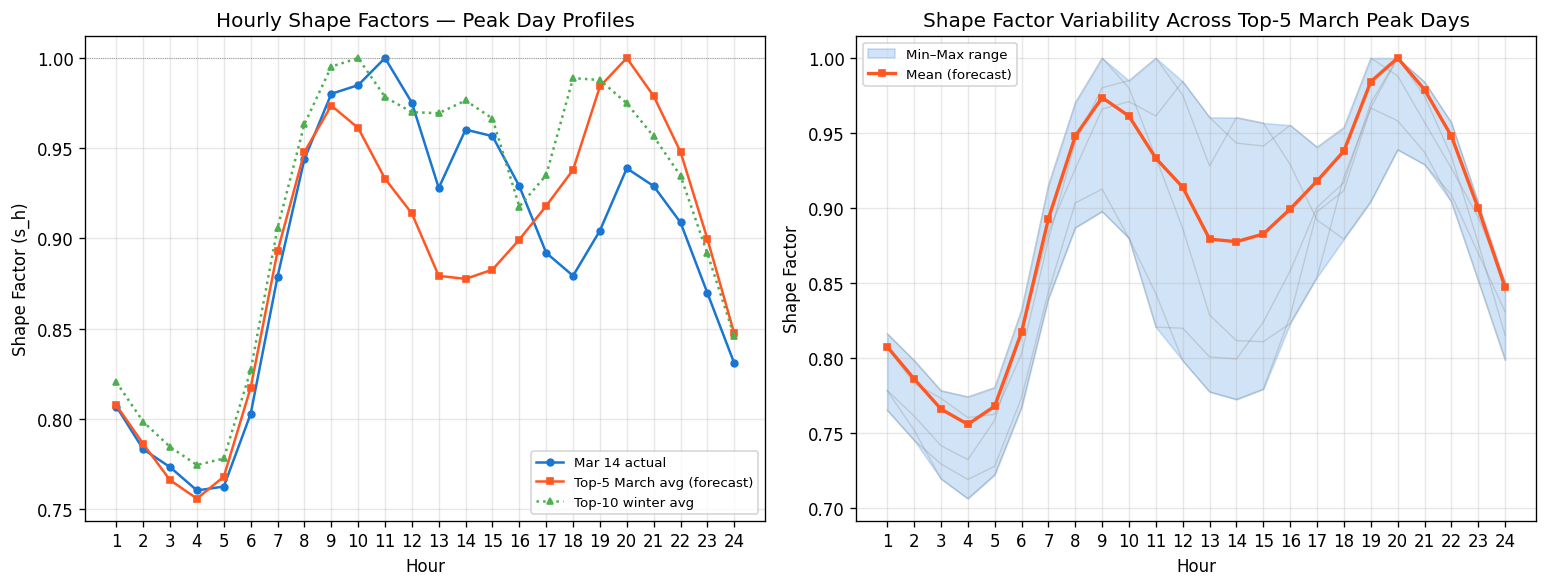

In [41]:
# March 14 actual
mar14_data = df[df['Date'] == pd.Timestamp('2025-03-14')].sort_values('Hour')
mar14_shape = mar14_data['Load'].values / mar14_data['Load'].max()

# Top-10 winter weekday average (Dec–Mar)
winter_wd = daily[(daily['Month'].isin([12, 1, 2, 3])) & (daily['IsWeekday'] == 1)]
top10_winter = winter_wd.nlargest(10, 'PeakLoad')['Date'].values
winter_shape = np.zeros(24)
for d in top10_winter:
    ddata = df[df['Date'] == d].sort_values('Hour')
    winter_shape += ddata['Load'].values / ddata['Load'].max()
winter_shape /= len(top10_winter)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
ax.plot(range(1,25), mar14_shape, 'o-', color='#1976D2', lw=1.5, ms=4, label='Mar 14 actual')
ax.plot(range(1,25), shape_forecast, 's-', color='#FF5722', lw=1.5, ms=4, label='Top-5 March avg (forecast)')
ax.plot(range(1,25), winter_shape/winter_shape.max(), '^:', color='#4CAF50', lw=1.5, ms=4, label='Top-10 winter avg')
ax.set_xlabel('Hour'); ax.set_ylabel('Shape Factor (s_h)')
ax.set_title('Hourly Shape Factors — Peak Day Profiles')
ax.set_xticks(range(1,25)); ax.legend(fontsize=8)
ax.axhline(1.0, color='gray', ls=':', lw=0.5)

# Variability band, top-5 days
ax = axes[1]
all_shapes = []
for d in top5_dates:
    ddata = df[df['Date'] == d].sort_values('Hour')
    s = ddata['Load'].values / ddata['Load'].max()
    all_shapes.append(s)
    ax.plot(range(1,25), s, '-', color='#888', alpha=0.3, lw=0.8)
all_shapes = np.array(all_shapes)
ax.fill_between(range(1,25), all_shapes.min(axis=0), all_shapes.max(axis=0), alpha=0.2, color='#1976D2', label='Min–Max range')
ax.plot(range(1,25), shape_forecast, 's-', color='#FF5722', lw=2, ms=4, label='Mean (forecast)')
ax.set_xlabel('Hour'); ax.set_ylabel('Shape Factor')
ax.set_title('Shape Factor Variability Across Top-5 March Peak Days')
ax.set_xticks(range(1,25)); ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

### Task 3(a).

Objective: Convert the March 2026 *monthly peak* forecast ($L^*$) (MW) into an *hourly* profile on the peak day using *shape factors*.

Definition: Let ($L_h$) be the load at hour ($h$) in $\{1,\dots,24\}$ on the peak day ($d^*$). Define
$$
s_h=\frac{L_h}{L^*}, \quad \text{where } L^*=\max_h(L_h).
$$
By construction, ($\max_h(s_h)=1$) and the peak hour satisfies ($L_{h^*}=L^*$).

Estimation method (data-driven template).

1. Identify the **top-5 highest daily-peak weekdays in March 2025** (same seasonality regime as March; weekdays avoid weekend pattern shifts).
2. For each selected day ($d$), compute its normalized hourly profile:
$$
\tilde{s}_{h,d}=\frac{L_{h,d}}{\max_h(L_{h,d})}.
$$
3. Average the normalized profiles across the five days to obtain a stable “peak-day” shape:
$$
\bar{s}_h=\frac{1}{5}\sum_{d\in\text{Top5}}\tilde{s}_{h,d}.
$$
4. Renormalize to enforce ($\max_h(s_h)=1$):
$$
s_h=\frac{\bar{s}_h}{\max_h(\bar{s}_h)}.
$$

Hourly forecast construction. Given the monthly peak forecast ($L^*$) (Task 1a), the hourly peak-day forecast is:
$$
\hat{L}_h = L^* \cdot s_h, \quad h=1,\dots,24,
$$
and the forecast peak hour is ($h^*=\arg\max_h s_h$).

Sanity checks.

- ($\max_h(s_h)=1$) (shape factors are internally consistent).
- ($\max_h(\hat{L}_h)=L^*$) (hourly profile peaks at the monthly peak forecast).

---

### Task 3(b)

If the LSE's hourly load profile differs from CAISO's aggregate profile, then the **shape factors must be estimated from the LSE's own hourly loads**, not from CAISO system load. The definition is the same:

$$
s_h := \frac{\mathrm{LSE}_h}{\mathrm{LSE}^*}, \quad \text{where } \mathrm{LSE}^*=\max_{h=1,\dots,24}\mathrm{LSE}_h,
$$

but both the peak hour and the within-day shape can change.

### What changes from Task 3(a):

1. **Data source:** Replace CAISO hourly load ($L_h^{\text{CAISO}}$) with the LSE's hourly load ($\mathrm{LSE}_h$) on historical days.  
2. **Analog-day selection:** Select analog peak days using the LSE's **daily peak** (e.g., top-$N$ peak weekdays in March of the historical year), because the LSE's peak day may not coincide with CAISO's peak day.  
3. **Shape estimation (same procedure):** For each selected day ($d$), normalize the LSE profile by its daily max:
   $$
   \tilde{s}_{h,d}=\frac{\mathrm{LSE}_{h,d}}{\max_h \mathrm{LSE}_{h,d}},
   $$
   average across selected days, then renormalize so $\max_h s_h=1$. Forecast hourly loads on ($d^*$) via
   $$
   \widehat{\mathrm{LSE}}_h = \mathrm{LSE}^{**}\cdot s_h.
   $$

**Why it changes:** Different customer mix and geography shift the intraday profile (e.g., a residential-heavy LSE tends to have a stronger evening peak; a commercial-heavy LSE tends to peak during business hours). Therefore the estimated ($s_h$) (and possibly the peak hour) can differ materially from CAISO's ($s_h$).

---

### Task 3(c)

**(See task 3(a) code cell for implementation)**

- Inputs from Task 1: $L^* = 25{,}549\ \mathrm{MW}$, $d^* = 03/04/2026$. Define shape factors $s_h := L_h/L^*$ for $h=1,\ldots,24$, where $L^*=\max_h L_h$.
- Method (implemented): Identify the top-5 March 2025 weekday peak days (03/14, 03/05, 03/25, 03/04, 03/24). For each day $d$, compute its normalized hourly profile $\tilde{s}_{h,d}=L_{h,d}/\max_h L_{h,d}$, average across the five days, then renormalize so $\max_h(s_h)=1$. Forecast hourly loads via $\hat{L}_h=L^*\cdot s_h$.
- Results: The 24 shape factors $\{s_h\}_{h=1}^{24}$ and hourly forecasts $\{\hat{L}_h\}$ are reported in the notebook output. Internal consistency holds: the forecast peak hour is **Hour 20** with $s_{20}=1.0000$, and $\max_h(\hat{L}_h)=25{,}549\ \mathrm{MW}=L^*$.
- Supporting evidence: Two plots are included: (1) forecast shape vs. the 03/14/2025 observed profile and a winter-average profile, and (2) a min–max variability band across the five analog days with the forecast mean overlaid.

---

# 8 Task 4

### Task 4(a) No

---

### Task 4(b) N/A

---

### Task 4(c) Yes


---

### Task 4(d) Claude Opus 4.6


---

### Task 4(e) No


---

### Task 4(f) N/A


---